In [4]:
using Pkg; Pkg.activate("C:\\Users\\KarlH\\Desktop\\ComputationalPhysicsMaster\\Code\\OrbitalNeuralMethods")
using Revise
using OrbitalNeuralMethods

  Activating project at `C:\Users\KarlH\Desktop\ComputationalPhysicsMaster\Code\OrbitalNeuralMethods`


In [14]:
using PyFormattedStrings
import Plots as plt
plt.pyplot()

Plots.PyPlotBackend()

In [7]:
l = 10
ω = 0.25
basis = SpinBasis(HOBasis(l, ω))

n = 2
V = HOCoulomb(ω, shielding = 0.25)
grid = [x for x in range(-10, stop = 10, length = 2001)]
system = System(n, basis, grid, V);

In [9]:
hf = HF(system);
compute_ground_state!(hf, max_iter = 1000, tol = 1e-10)

rhf = RHF(system);
compute_ground_state!(rhf, max_iter = 1000, tol = 1e-10);

## Density Setup

In [10]:
function single_det_particle_density(system)
    (;spfs, n) = system
    
    particle_density = zero(spfs[1])
    for i in 1:n
        particle_density .+= spfs[i].^2
    end
    return particle_density
end

single_det_particle_density (generic function with 1 method)

In [6]:
function CCSD_particle_density(state)
    (;system, t1) = state
    (;spfs, l, n)  = system
    
    cc_dens = zero(spfs[1])
    for p in 1:l
        for q in 1:l
            if p == q && p <= n
                cc_dens .+= spfs[p] .* spfs[q]
            elseif q <= n && p > n
                cc_dens .+= spfs[p] .* spfs[q] .* t1[p, q]
            end
        end
    end
    return cc_dens
end

CCSD_particle_density (generic function with 1 method)

In [7]:
import FileIO
import ColorVectorSpace
function imgplot(;file, extent, imgalpha, xticks, yticks)
    img = FileIO.load(file) .- ColorVectorSpace.RGBA(0, 0, 0, 1 - imgalpha)
    
    h, w = size(img)
    x0, x1, y0, y1 = extent
    dx = x1 - x0
    x_mid = (x0 + x1) / 2
    dy = y1 - y0
    
    plt.plot(img,
             xlim = (0, w),
             ylim = (0, h),
             yticks = h .- (yticks .- y0) .* h ./ dy,
             xticks = (xticks .+ dx ./ 2) .* w ./ dx,
             grid = true, gridalpha = 0.7,
             size = (600, 400),
             xformatter = x -> round((x / w - 0.5 + x_mid/dx) * dx, digits = 1),
             yformatter = y -> round((-y / h * dy + y0 + dy), digits = 10),
             )
    return x -> (x - x_mid + dx/2) * w / dx, y -> h - (y - y0) * h / dy
end

imgplot (generic function with 1 method)

## Particle Density

In [13]:
sys_ho = system
ho_density = single_det_particle_density(sys_ho)

ccsd_ho = setup_CCSD(sys_ho)
compute_ground_state!(ccsd_ho);
ccsd_ho_density = CCSD_particle_density(ccsd_ho);

In [12]:
sys_rhf = System(rhf)
rhf_density = single_det_particle_density(sys_rhf)
sys_hf = System(hf)
hf_density = single_det_particle_density(sys_hf);

┌ Warning: linestyle dashdotdot is unsupported with Plots.PyPlotBackend().  Choose from: [:auto, :dash, :dashdot, :dot, :solid]
└ @ Plots C:\Users\KarlH\.julia\packages\Plots\nbICw\src\args.jl:1658


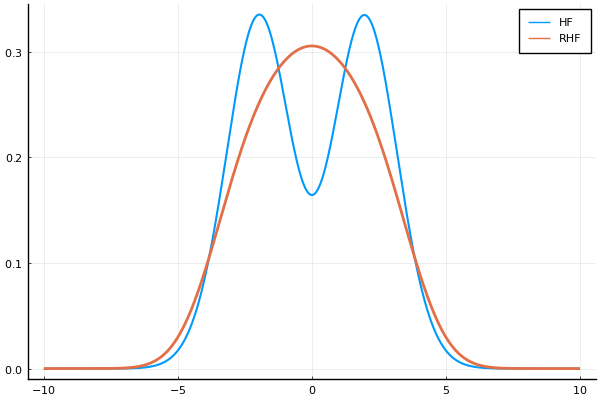

┌ Warning: Unknown linestyle dashdotdot
└ @ Plots C:\Users\KarlH\.julia\packages\Plots\nbICw\src\backends\pyplot.jl:127
┌ Warning: Unknown linestyle dashdotdot
└ @ Plots C:\Users\KarlH\.julia\packages\Plots\nbICw\src\backends\pyplot.jl:127


┌ Error: Error watching manifest
│   exception = (Revise.ReviseEvalException("C:\\Users\\KarlH\\.julia\\packages\\JLLWrappers\\QpMQW\\src\\toplevel_generators.jl:156", MethodError(Glib_jll.var"#make_wrapper_dict#4"{Glib_jll.var"#parse_wrapper_platform#3"}(Glib_jll.var"#parse_wrapper_platform#3"()), ("C:\\Users\\KarlH\\.julia\\packages\\Glib_jll\\QfIde\\src", ["aarch64-apple-darwin.jl", "aarch64-linux-gnu.jl", "aarch64-linux-musl.jl", "armv6l-linux-gnueabihf.jl", "armv6l-linux-musleabihf.jl", "armv7l-linux-gnueabihf.jl", "armv7l-linux-musleabihf.jl", "i686-linux-gnu.jl", "i686-linux-musl.jl", "i686-w64-mingw32.jl", "powerpc64le-linux-gnu.jl", "x86_64-apple-darwin.jl", "x86_64-linux-gnu.jl", "x86_64-linux-musl.jl", "x86_64-unknown-freebsd.jl", "x86_64-w64-mingw32.jl"]), 0x0000000000007ecf), Any[(top-level scope at toplevel_generators.jl:156, 1)]), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x0000000100f1cefa])
└ @ Revise C:\Users\KarlH\.julia\packages\Revise\do2nH\src\pkgs.jl:

In [15]:
plt.plot(grid, hf_density, label="HF", lw=1.5, c=1)
plt.plot!(grid, rhf_density, label="RHF", ls=:dashdotdot, lw=2, c=2)

In [8]:
ccsd_rhf = setup_CCSD(sys_rhf)
compute_ground_state!(ccsd_rhf);
ccsd_rhf_density = CCSD_particle_density(ccsd_rhf)

ccsd_hf = setup_CCSD(sys_hf)
compute_ground_state!(ccsd_hf);
ccsd_hf_density = CCSD_particle_density(ccsd_hf);

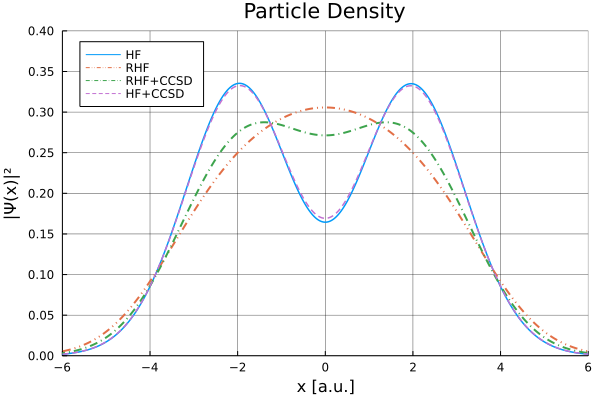

In [18]:
plt.plot(legend=:topleft, title="Particle Density", xlabel="x [a.u.]", ylabel="|Ψ(x)|²", xlim=(-6, 6), ylim=(0, 0.4), grid = true, gridalpha = 0.7,
        xticks=[x for x in -6:2:6], yticks=[y for y in 0:0.05:0.4], size = (600, 400))
plt.plot!(grid, hf_density, label="HF", lw=1.5, c=1)
plt.plot!(grid, rhf_density, label="RHF", ls=:dashdotdot, lw=2, c=2)
plt.plot!(grid, ccsd_rhf_density, label="RHF+CCSD", ls=:dashdot, lw=2, c=3)
plt.plot!(grid, ccsd_hf_density, label="HF+CCSD", ls=:dash, lw=1.5, c=4)
plt.savefig("Figures/particle_dens.png")
plt.plot!()

┌ Info: Precompiling PNGFiles [f57f5aa1-a3ce-4bc8-8ab9-96f992907883]
└ @ Base loading.jl:1662


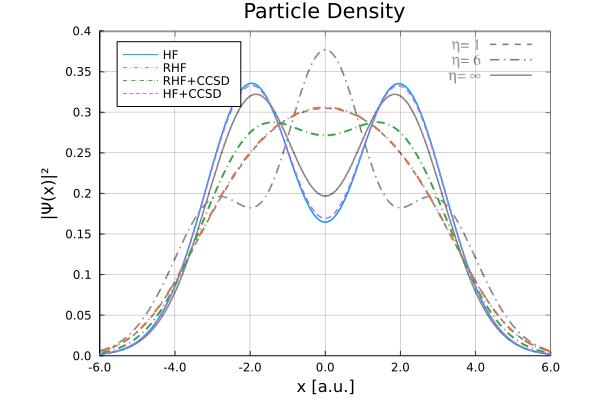

In [9]:
x_trans, y_trans = imgplot(file     = "Figures/GS.PNG",
                           extent   = [-6, 6, 0, 0.4],
                           imgalpha = 0.5,
                           yticks   = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
                           xticks   = [x for x in -6:2:6],
                           )

plt.plot!(legend=:topleft, title="Particle Density", xlabel="x [a.u.]", ylabel="|Ψ(x)|²")
plt.plot!(x_trans.(grid), y_trans.(hf_density), label="HF", lw=1.5, c=1)
plt.plot!(x_trans.(grid), y_trans.(rhf_density), label="RHF", ls=:dashdotdot, lw=2, c=2)
plt.plot!(x_trans.(grid), y_trans.(ccsd_rhf_density), label="RHF+CCSD", ls=:dashdot, lw=2, c=3)
plt.plot!(x_trans.(grid), y_trans.(ccsd_hf_density), label="HF+CCSD", ls=:dash, lw=1.5, c=4)
plt.savefig("Figures/particle_dens_zang.png")
plt.plot!()